Trying out varrious approcahes to try and create a model abble to classify reviews into five classes (5 stars). Data used is from Kaggle (Yelp User Review Dataset)

---



In [1]:
import logging
import pandas as pd
import numpy as np
from numpy import random
import gensim
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import re
from bs4 import BeautifulSoup
%matplotlib inline
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [2]:
data = pd.read_csv("/content/drive/MyDrive/yelp.csv")

In [3]:
data.drop(['business_id','date','review_id','type','user_id','cool','useful','funny'], axis=1, inplace=True)

In [4]:
data.stars.astype(int)
data.stars.unique()

array([5, 4, 2, 3, 1])

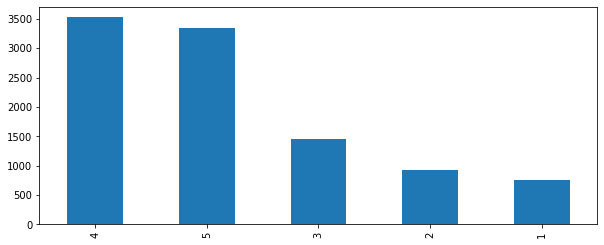

In [6]:
stars = ['5', '4', '3', '2', '1']
plt.figure(figsize=(10,4))
data.stars.value_counts().plot(kind='bar');

In [7]:
def print_plot(index):
    example = data[data.index == index][['text', 'stars']].values[0]
    if len(example) > 0:
        print(example[0])
        print('Star:', example[1])

print_plot(20)

DVAP....

You have to go at least once in your life. It really is a neat place with alot of history. 

The service is great, it appears to be family run. 

The food is good. Better then Dennys but not as good as Mimi's. 

I had the all u can eat of beef ribs, lasagna, meat loaf, cat fish, chicken, mashed and diced potatoes, stuffing, rice, homemade apple pie, etc and salad bar. I know I am missing a bunch of stuff they had but you get the drift. 

They run specials on Prime rib and stuff so you might want to call to see what they are serving the night you go.
Star: 3


In [8]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    text = BeautifulSoup(text, "lxml").text # HTML decoding
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwors from text
    return text
    
data['post'] = data['text'].apply(clean_text)

DVAP....

You have to go at least once in your life. It really is a neat place with alot of history. 

The service is great, it appears to be family run. 

The food is good. Better then Dennys but not as good as Mimi's. 

I had the all u can eat of beef ribs, lasagna, meat loaf, cat fish, chicken, mashed and diced potatoes, stuffing, rice, homemade apple pie, etc and salad bar. I know I am missing a bunch of stuff they had but you get the drift. 

They run specials on Prime rib and stuff so you might want to call to see what they are serving the night you go.
Star: 3


In [9]:
data

,stars,text,post
0,5,My wife took me here on my birthday for breakf...,wife took birthday breakfast excellent weather...
1,5,I have no idea why some people give bad review...,idea people give bad reviews place goes show p...
2,4,love the gyro plate. Rice is so good and I als...,love gyro plate rice good also dig candy selec...
3,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",rosie dakota love chaparral dog park convenien...
4,5,General Manager Scott Petello is a good egg!!!...,general manager scott petello good egg go deta...
...,...,...,...
9995,3,First visit...Had lunch here today - used my G...,first visithad lunch today used groupon ordere...
9996,4,Should be called house of deliciousness!\n\nI ...,called house deliciousnessi could go item item...
9997,4,I recently visited Olive and Ivy for business ...,recently visited olive ivy business last week ...
9998,2,My nephew just moved to Scottsdale recently so...,nephew moved scottsdale recently bunch friends...


In [10]:
data['post'].apply(lambda x: len(x.split(' '))).sum()

675092

In [11]:
X = data.post
y = data.stars
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)

**Naive Bayes Classifier**

---



In [12]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])
nb.fit(X_train, y_train)

#%%time
from sklearn.metrics import classification_report
y_pred = nb.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=stars))

accuracy 0.43733333333333335
              precision    recall  f1-score   support

           5       0.00      0.00      0.00       218
           4       0.00      0.00      0.00       265
           3       0.00      0.00      0.00       442
           2       0.40      0.88      0.55      1087
           1       0.61      0.36      0.45       988

    accuracy                           0.44      3000
   macro avg       0.20      0.25      0.20      3000
weighted avg       0.34      0.44      0.35      3000



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**Linear Support Vector Machine**

---



In [13]:
from sklearn.linear_model import SGDClassifier

sgd = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)),
               ])
sgd.fit(X_train, y_train)

#%%time

y_pred = sgd.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=stars))

accuracy 0.5103333333333333
              precision    recall  f1-score   support

           5       0.58      0.41      0.48       218
           4       0.48      0.19      0.27       265
           3       0.39      0.14      0.20       442
           2       0.52      0.49      0.51      1087
           1       0.51      0.80      0.63       988

    accuracy                           0.51      3000
   macro avg       0.50      0.41      0.42      3000
weighted avg       0.50      0.51      0.48      3000



**Logistic Regression**


---





In [14]:
from sklearn.linear_model import LogisticRegression

logreg = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(n_jobs=1, C=1e5)),
               ])
logreg.fit(X_train, y_train)

#%%time

y_pred = logreg.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=stars))

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


accuracy 0.48433333333333334
              precision    recall  f1-score   support

           5       0.60      0.43      0.50       218
           4       0.38      0.37      0.37       265
           3       0.35      0.35      0.35       442
           2       0.49      0.49      0.49      1087
           1       0.54      0.58      0.56       988

    accuracy                           0.48      3000
   macro avg       0.47      0.44      0.45      3000
weighted avg       0.49      0.48      0.48      3000



**Keras**

---



In [15]:
import itertools
import os

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import confusion_matrix

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.preprocessing import text, sequence
from keras import utils

In [16]:
train_size = int(len(data) * .7)
train_posts = data['post'][:train_size]
train_tags = data['stars'][:train_size]

test_posts = data['post'][train_size:]
test_tags = data['stars'][train_size:]

In [17]:
max_words = 1000
tokenize = text.Tokenizer(num_words=max_words, char_level=False)
tokenize.fit_on_texts(train_posts) # only fit on train

x_train = tokenize.texts_to_matrix(train_posts)
x_test = tokenize.texts_to_matrix(test_posts)

encoder = LabelEncoder()
encoder.fit(train_tags)
y_train = encoder.transform(train_tags)
y_test = encoder.transform(test_tags)

num_classes = np.max(y_train) + 1
y_train = utils.to_categorical(y_train, num_classes)
y_test = utils.to_categorical(y_test, num_classes)

batch_size = 32
epochs = 10

In [18]:
# Build the model
model = Sequential()
model.add(Dense(512, input_shape=(max_words,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
              
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)

Epoch 1/10
197/197 [==============================] - 2s 8ms/step - loss: 1.3686 - accuracy: 0.4020 - val_loss: 1.1216 - val_accuracy: 0.5171
Epoch 2/10
197/197 [==============================] - 1s 5ms/step - loss: 0.9038 - accuracy: 0.6372 - val_loss: 1.1222 - val_accuracy: 0.5300
Epoch 3/10
197/197 [==============================] - 1s 5ms/step - loss: 0.7302 - accuracy: 0.7312 - val_loss: 1.1600 - val_accuracy: 0.5186
Epoch 4/10
197/197 [==============================] - 1s 5ms/step - loss: 0.5781 - accuracy: 0.8056 - val_loss: 1.1965 - val_accuracy: 0.5057
Epoch 5/10
197/197 [==============================] - 1s 5ms/step - loss: 0.4394 - accuracy: 0.8641 - val_loss: 1.2665 - val_accuracy: 0.4914
Epoch 6/10
197/197 [==============================] - 1s 5ms/step - loss: 0.3272 - accuracy: 0.9179 - val_loss: 1.3321 - val_accuracy: 0.5071
Epoch 7/10
197/197 [==============================] - 1s 5ms/step - loss: 0.2409 - accuracy: 0.9484 - val_loss: 1.3919 - val_accuracy: 0.5114
Epoch 